# <center>Toxic or Tame?<br> Classifying Chat Comments with NLP</center>

<div style="text-align: center;">
  <img src="https://plus.unsplash.com/premium_photo-1681487872232-fa622a6dd59e?q=80&w=2080&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D" alt="A chatbox" style="width: 350px;">
</div>

## Introduction
In this project, the aim is to develop a robust system for classifying chat comments as either toxic or non-toxic using Natural Language Processing (NLP) techniques. The widespread use of online communication platforms has created a pressing need to maintain respectful and productive dialogue. Automating the detection of toxic language is intended to enhance user experience and foster healthier online interactions.

To achieve this objective, the approach involves leveraging machine learning algorithms and NLP libraries to analyse textual data extracted from chat logs. Initial steps include preprocessing and cleaning the data to address common challenges such as spelling errors, punctuation, and capitalisation inconsistencies. Subsequently, a supervised learning approach will be implemented, training a classification model on labelled datasets. This model will learn to differentiate between toxic and non-toxic comments based on features extracted from the text, such as word frequencies and contextual information. Evaluation metrics will assess the model's performance, ensuring its effectiveness in accurately identifying harmful content. Ultimately, the goal is to contribute to the development of tools that promote safer and more respectful online communities.

## Contents
- 1.0 Data importing
- 2.0 EDA
- 3.0 Preparing data for sentiment analysis
- 4.0 Sentiment Analysis
- 5.0 Performance Analysis
- 6.0 Toxic comment classifier
- 7.0 Conclusions and Limitations

# 1.0 Data importing

## 1.1 Data importing and dictionary

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import itertools
from collections import Counter
import re # allows advance text preprocessing
import string # Get a list of puctuation
from spellchecker import SpellChecker # Analyses and coorrects typos in texts

# Natural laguage Tokenizer
import nltk 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.snowball import SnowballStemmer

# Modelling
from sklearn.feature_extraction.text import CountVectorizer # Explain latre
from sklearn.linear_model import LogisticRegression
## Import the metrics we'll be using
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score # Model metric analysis
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Pre-Trained models
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer # VADER: import SentimentIntensityAnalyzer class
from transformers import BertTokenizer, BertForSequenceClassification # BERT:Bidirectional Encoder Representations from Transformers (pre-trained model)
import torch

**Note**: 
Accessing chat logs for all players in games, particularly those with large player bases, is generally restricted due to privacy policies and data protection regulations. Game developers and publishers are very careful about sharing personal data, including chat logs, to comply with privacy laws such as the GDPR (General Data Protection Regulation) in Europe and the CCPA (California Consumer Privacy Act) in the United States. Therefore, we will be using data obtained from the Kaggle competition project "Toxic Comment Classification Challenge".

In [ ]:
# Import data from csv files
train = pd.read_csv('train.csv', header=None)
train_df = train.copy()
train_df.columns = train_df.iloc[0] # Set our column headers
train_df = train_df[1:]

test_label = pd.read_csv('test_labels.csv', header=None)
test_label.columns = test_label.iloc[0]
test_label = test_label[1:]

test = pd.read_csv('test.csv', header=None)
test.columns = test.iloc[0]
test = test[1:]

## 1.2 Data Description

**id**:<br>
A unique identifier for each comment - designated to a specific user.<br>
Data Type: String or numeric identifier.

**comment_text**:<br>
Description: The main content of the comment.<br>
Data Type: String.

**toxic**:<br>
Description: Indicates whether the comment contains toxic content.<br>
Data Type: Boolean (1 for toxic, 0 for non-toxic).

**severe_toxic**:<br>
Description: Indicates whether the comment contains severe toxic content.<br>
Data Type: Boolean (1 for severe toxic, 0 for non-severe toxic).

**obscene**:<br>
Description: Indicates whether the comment is obscene.<br>
Data Type: Boolean (1 for obscene, 0 for non-obscene).

**threat**:<br>
Description: Indicates whether the comment contains threats.<br>
Data Type: Boolean (1 for threats present, 0 for no threats).

**insult**:<br>
Description: Indicates whether the comment is insulting.<br>
Data Type: Boolean (1 for insulting, 0 for non-insulting).

**identity_hate**:<br>
Description: Indicates whether the comment exhibits identity-based hate.

## 1.3 File descriptions

**train.csv**:<br>
The training set, contains comments with their binary labels

**test.csv**:<br>
The test set, you must predict the toxicity probabilities for these comments. To deter hand labeling, the test set contains some comments which are not included in scoring.

**sample_submission.csv**:<br>
A sample submission file in the correct format

**test_labels.csv**:<br>
Labels for the test data; value of -1 indicates it was not used for scoring; (Note: file added after competition close!)

# 2.0 EDA

## 2.1 Check for nulls

In [18]:
# Checking for nulls in train_df
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 1 to 159571
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  object
 3   severe_toxic   159571 non-null  object
 4   obscene        159571 non-null  object
 5   threat         159571 non-null  object
 6   insult         159571 non-null  object
 7   identity_hate  159571 non-null  object
dtypes: object(8)
memory usage: 9.7+ MB


In [19]:
# Checking for nulls in test_label
test_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153164 entries, 1 to 153164
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             153164 non-null  object
 1   toxic          153164 non-null  object
 2   severe_toxic   153164 non-null  object
 3   obscene        153164 non-null  object
 4   threat         153164 non-null  object
 5   insult         153164 non-null  object
 6   identity_hate  153164 non-null  object
dtypes: object(7)
memory usage: 8.2+ MB


In [20]:
# Checking for nulls in test
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153164 entries, 1 to 153164
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            153164 non-null  object
 1   comment_text  153164 non-null  object
dtypes: object(2)
memory usage: 2.3+ MB


In [21]:
# Check if test / test_label id's match
id_match = test['id'].equals(test_label['id'])
id_match

True

**Summary**<br>
The dataset is devoid of any null values, ensuring completeness and reliability across all its entries. Moreover, every user ID present in the test data is accurately reflected in the corresponding test_labels, reinforcing the integrity and alignment between user identifiers and their associated labels. This consistency underscores the dataset's suitability for robust analysis and dependable predictive modelling.

## 2.3 Removing test data containing -1

**Note** Rows in the testing set that contain -1 represent newly added data without actual target results and therefore should be excluded from analysis. (Refer to Section 1.2, Data Description, for further details.)

In [26]:
# Setting the id column as the index (since they are all unique to a comment)
test = test.set_index('id')
test_label = test_label.set_index('id')
train_df = train_df.set_index('id') # will also apply to the training set for consistency.
test_df = test.join(test_label, how='left')

**Changing column datatypes**

In [28]:
# Change dtype for training data 
columns_to_convert = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train_df[columns_to_convert] = train_df[columns_to_convert].astype(int)

In [29]:
# Change dtype for test data 
test_df[columns_to_convert] = test_df[columns_to_convert].astype(int)

In [30]:
# Replace -1 with NaN in tetsing set
test_df.replace(-1, np.nan, inplace=True)

# Drop rows with NaN values in any column
test_df = test_df.dropna()

In [31]:
test_df.shape

(63978, 7)

In [32]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63978 entries, 0001ea8717f6de06 to fffb5451268fb5ba
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   comment_text   63978 non-null  object 
 1   toxic          63978 non-null  float64
 2   severe_toxic   63978 non-null  float64
 3   obscene        63978 non-null  float64
 4   threat         63978 non-null  float64
 5   insult         63978 non-null  float64
 6   identity_hate  63978 non-null  float64
dtypes: float64(6), object(1)
memory usage: 3.9+ MB


**Checking all unique values**

In [34]:
# Test: All unique values
# Define the columns to check
columns_to_check = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Find all unique values in the specified columns
unique_values = pd.unique(train_df[columns_to_check].values.ravel())

# Print the unique values
print(unique_values)

[0 1]


In [35]:
# Train: All unique values
# Define the columns to check
columns_to_check = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Find all unique values in the specified columns
unique_values = pd.unique(test_df[columns_to_check].values.ravel())

# Print the unique values
print(unique_values)

[0. 1.]


**Note:** We can now confirm that there are no unexpected values and that all values are boolean (1/0).

## 2.4 Combining boolean columns to a single target column

In [39]:
train_df.head(5)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [40]:
test_df.head(5)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0001ea8717f6de06,Thank you for understanding. I think very high...,0.0,0.0,0.0,0.0,0.0,0.0
000247e83dcc1211,:Dear god this site is horrible.,0.0,0.0,0.0,0.0,0.0,0.0
0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0.0,0.0,0.0,0.0,0.0,0.0
0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0.0,0.0,0.0,0.0,0.0,0.0
00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
# Create a function that combines all target columns into a single column
def add_indicator_column(df, new_col_name, remove_original_cols=True):
    columns_to_check = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    """
    Add a new column to the DataFrame based on a condition:
    If all specified columns in a row are zero, the new column will have a value of 0.
    Otherwise, the new column will have a value of 1.
    Optionally, remove the original columns used to create the new column.

    Parameters
    ----------
    df : pandas.DataFrame
        The input DataFrame.
    columns_to_check : list of str
        List of column names to check.
    new_col_name : str
        The name of the new column to add.
    remove_original_cols : bool, optional (default=True)
        Whether to remove the original columns after creating the new column.

    Returns
    -------
    pandas.DataFrame
        The DataFrame with the new column added and optionally with original columns removed.
    """
    df[new_col_name] = df[columns_to_check].apply(lambda row: 0 if (row == 0).all() else 1, axis=1)
    
    if remove_original_cols:
        df.drop(columns=columns_to_check, inplace=True)
    
    return df

In [42]:
# Apply function to training data
add_indicator_column(train_df, "review_comment")

,comment_text,review_comment
id,,
0000997932d777bf,Explanation\nWhy the edits made under my usern...,0
000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0
0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0
0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0
...,...,...
ffe987279560d7ff,""":::::And for the second time of asking, when ...",0
ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0
ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0


In [43]:
# Apply function to Testing data
add_indicator_column(test_df, "review_comment")

,comment_text,review_comment
id,,
0001ea8717f6de06,Thank you for understanding. I think very high...,0
000247e83dcc1211,:Dear god this site is horrible.,0
0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0
0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0
00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0
...,...,...
fff8f64043129fa2,":Jerome, I see you never got around to this…! ...",0
fff9d70fe0722906,==Lucky bastard== \n http://wikimediafoundatio...,0
fffa8a11c4378854,==shame on you all!!!== \n\n You want to speak...,0


In [44]:
train_df.head()

,comment_text,review_comment
id,,
0000997932d777bf,Explanation\nWhy the edits made under my usern...,0
000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0
0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0
0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0


In [45]:
test_df.head()

,comment_text,review_comment
id,,
0001ea8717f6de06,Thank you for understanding. I think very high...,0
000247e83dcc1211,:Dear god this site is horrible.,0
0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0
0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0
00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0


## 2.5 Investiating class balance

In [48]:
# Number of obervations of true / false results
train_df['review_comment'].value_counts()

review_comment
0    143346
1     16225
Name: count, dtype: int64

In [49]:
# proportion of obervations of true / false results
train_df['review_comment'].value_counts(normalize = True)

review_comment
0    0.898321
1    0.101679
Name: proportion, dtype: float64

In [50]:
train_df.shape

(159571, 2)

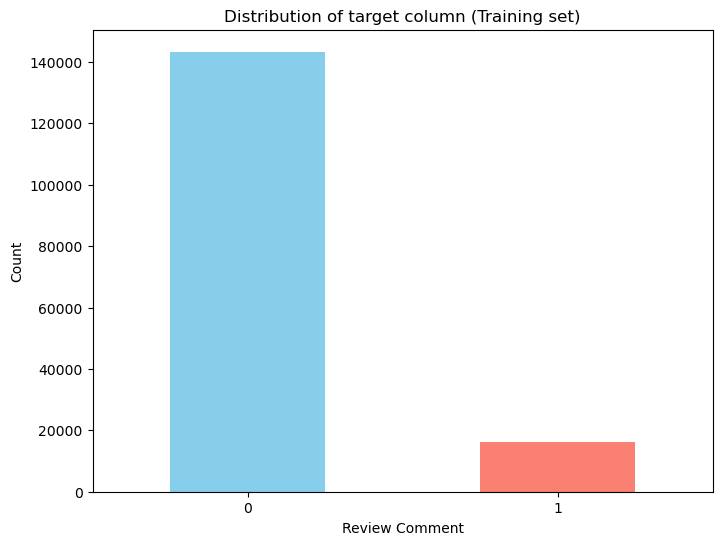

In [51]:
# Count the values
value_counts = train_df['review_comment'].value_counts()

# Plotting the bar chart
plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of target column (Training set)')
plt.xlabel('Review Comment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

**Note:** The count of false (0) results exceeds that of true (1) results by ninefold. Hence, we will need to undersample the false results to achieve 16225 observations, aligning with the number of true rows.

**Random Undersampling**

In [54]:
# Creating new DF with a perfect class balance - balanced_df
df_false = train_df[train_df['review_comment'] == 0]

# Randomly sample 16225 rows from df_0
sampled_df_false = df_false.sample(n=16225, random_state=30)

# Select rows where target_col equals 1
df_true = train_df[train_df['review_comment'] == 1]

# Concatenate sampled_df_0 and df_1 to form the final balanced dataset
balanced_df = pd.concat([sampled_df_false, df_true], axis=0)

# Shuffle the dataset
balanced_df = balanced_df.sample(frac=1, random_state=30).reset_index(drop=True)

# Print the shape of the balanced dataset to verify
print(balanced_df.shape)

(32450, 2)


In [55]:
# Check the number of obervations of true / false results
balanced_df['review_comment'].value_counts()

review_comment
1    16225
0    16225
Name: count, dtype: int64

In [56]:
# Double check the distribution
balanced_df['review_comment'].value_counts(normalize = True)

review_comment
1    0.5
0    0.5
Name: proportion, dtype: float64

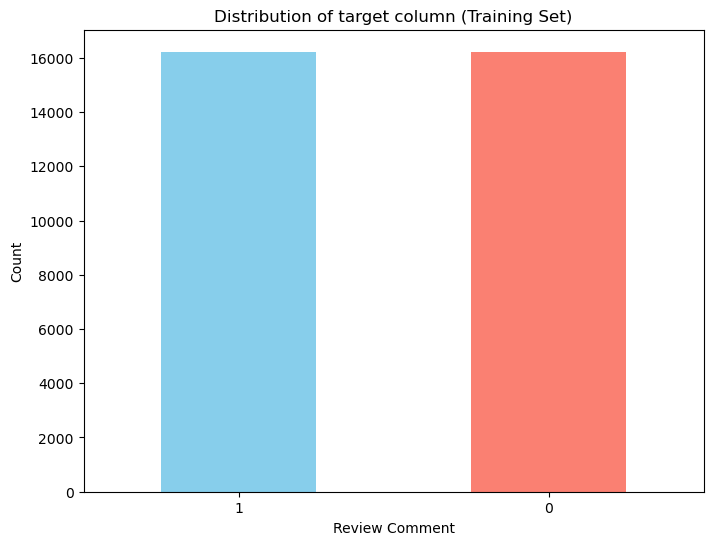

In [57]:
# Count the values
value_counts = balanced_df['review_comment'].value_counts()

# Plotting the bar chart
plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of target column (Training Set)')
plt.xlabel('Review Comment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

## 3.0 Preparing data for sentiment analysis

In [60]:
## Reuse regex function from before
# Takes something we want to remove and removes it (From prev notebook)

def regex_clean(txt, regex):
    """Replace any text matching the regex

    Parameters
    ----------
    txt : string
        A text string that you want to parse and remove matches
    regex : string 
        A text string of the regex pattern you want to match

    Returns
    -------
    The same txt string with the matches removes
    """

    return " ".join(re.sub(regex, "", txt).split())

def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F" # emoticons
                           u"\U0001F300-\U0001F5FF" # symbols & pictographs
                           u"\U0001F680-\U0001F6FF" # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)



In [61]:
# Function to clean the commennts
def clean_comments(df):
    # Step 1: Lowercase all posts
    df['cleaned'] = df['comment_text'].apply(str.lower)

    # Step 2: Define a few regex patterns to clean! -- Not one size fits all!!!
    regex_to_clean = [r'(@.+?)\s', # Match the second half of an email address
                      r'\s\d+\s', # Match numbers
                      r'(//t.co/.+?)\s', # Match websites!
                      r'(//t.co/.+?)',
                      r"\b(?:n't|ve|ll|re|don|t|s|m)\b|\b(?:I've|don’t|don't)\b",
                      r'\n',
                      r':3',
                      r'\b\d+(\.\d+)?\b', # Numbs/decimal combinations
                      r'=+',
                      r'["\']+|\b\d+(\.\d+)?\b',
                      r'[\d.]+',
                      r'[^\w\s]'] # " and ' or repeats

    
    # step 2.2: Apply regex cleaning
    for reg in regex_to_clean:
        df['cleaned'] = df['cleaned'].apply(regex_clean, regex=reg)

    # Step : Apply emoji remover    
    df['cleaned'] = df['cleaned'].apply(remove_emoji)

In [62]:
# Create a copy of orginal comments
unclean_comments = balanced_df.copy()
# Apply to our df
clean_comments(balanced_df)
balanced_df.head()

,comment_text,review_comment,cleaned
0,"""\n\n Love Hina part:3 \n\nDamm you and your a...",1,love hina part damm you and your auto archivin...
1,Thanks for the link. I had seen am English la...,0,thanks for the link i had seen am english lang...
2,The opening paragraph states that the game is ...,0,the opening paragraph states that the game is ...
3,Most of these schools' entries read straight o...,0,most of these schools entries read straight ou...
4,Cameron Ward DJ \n\nYou have deleted a page th...,0,cameron ward dj you have deleted a page that i...


In [63]:
## Create/Declare some of the tools we might need

p_stemmer = PorterStemmer() # Stemming stratedy could in practice try multiple
stpwrd = nltk.corpus.stopwords.words('english') # Remove stopwords
stpwrd.extend(string.punctuation) # Remove punctuation


# Define a function to prepare our dataset
def prep_data(review):

    #Tokenizing!
    review = word_tokenize(review) # From what we have left we seperate terms/words into items in a list

    # Cleaning tokens!
    # Post Token Cleaning - Stuff that applies to a list
    review = [word for word in review if word not in stpwrd] # Keep all the words that are not stopwords
    review = [p_stemmer.stem(word) for word in review] # Apply stemmer (e.g 'apples' - 'apple')
    review = [word for word in review if word not in stpwrd] # Maybe the stemmer creates a stopword itself - Let's remove them (Probably not that common but good to have)
    review = [word for word in review if len(word)>2] # Remove small 1/2 letter words
    
    return review

## 4.0 Sentiment Analysis

### 4.1 Sentiment Analysis from scratch

**Using Porter Stemmer**

In [67]:
# Apply it on the testing data
balanced_df_train = balanced_df.copy()

In [68]:
# Accessing toxic words lexicon
# Specify path to text file
file_path = 'Toxic words dictionary.txt'

# Initialize an empty list to store the words
toxic_words = []

# Open the file and read its contents
with open(file_path, 'r', encoding='utf-8') as file:
    # Read each line and strip any newline characters
    for line in file:
        word = line.strip()  # Remove leading and trailing whitespace, including newline characters
        toxic_words.append(word)  # Add the cleaned word to the list

# print(toxic_words)

In [69]:
## Define a list of toxic words


# toxic_words = 'fuck,shit,bad,gross,wrong,awful,horrible,nasty,never,sad,hate,dirty,worst,cheap,dreadful,inferior,lousy,poor,terrible,unpleasant,unfortunate,subpar,abysmal,disgusting,repulsive,revolting,repugnant,dick,offensive,hypocrite,vile,nauseating,abhorrent,rude'.split(',')
# Note: added words e.g ('worst') -- Used generative ai for synonyms and list formatting
# Could use a library of online for more extensive lists -- pre existing libraries

## Apply porter stemming on these words
toxic_words = [p_stemmer.stem(word) for word in toxic_words]

## Define our own sentiment scoring function
def score_review(review):
    # Step 1:Prepare review - Tokenize
    review = prep_data(review)
    
    # Step 2: Score the review!
    negative_count = sum([1 for i in review if i in toxic_words])   # How many sad terms (+=1)
    # Try and except brach in case there was an empty review
    try:
        negative_score = round((negative_count) / len(review), 2) # % of terms sad
        neutral_score =  round((len(review) - negative_count) / len(review),2) # Everything else
    except ZeroDivisionError: # If empty
        neutral_score = 0
        negative_score = 0
    # Return the sentiment of the review: positve / negative / neutral
    return negative_score

In [70]:
## Creating a scoring (classification) function

def make_pred(score):
    score = score * 1 # Negative - Apply a positive weight -- May need to adjust weights
    
    if score > 0.10:
        return 1 # Classify as no review
    else:
        return 0 # Classify as review

In [71]:
# Add score column
balanced_df_train['negative_score'] = balanced_df_train['cleaned'].apply(score_review)

In [72]:
# Create a column with our predictions
balanced_df_train['pred'] = balanced_df_train['negative_score'].apply(make_pred)
balanced_df_train.head(5)

,comment_text,review_comment,cleaned,negative_score,pred
0,"""\n\n Love Hina part:3 \n\nDamm you and your a...",1,love hina part damm you and your auto archivin...,0.02,0
1,Thanks for the link. I had seen am English la...,0,thanks for the link i had seen am english lang...,0.00,0
2,The opening paragraph states that the game is ...,0,the opening paragraph states that the game is ...,0.00,0
3,Most of these schools' entries read straight o...,0,most of these schools entries read straight ou...,0.00,0
4,Cameron Ward DJ \n\nYou have deleted a page th...,0,cameron ward dj you have deleted a page that i...,0.00,0


In [73]:
# Accuracy checker
def accuracy_calc(df):
    df['accuracy'] = df['review_comment'] == df['pred']

    accuracy = df['accuracy'].mean() * 100
    print(f'Accuracy Score is {accuracy}%') # First attempt = 55% - Let's improve (change weighting and make list more extensive) current = Accuracy Score is 83.09707241910633%

In [74]:
# Apply accuracy checker
accuracy_calc(balanced_df_train)

Accuracy Score is 81.70416024653314%


**Porter Accuracy Score is 81.5808936825886%** <br/>
**Note:** The first iteration of the model yielded poor results (approximately 51%), prompting the next step of enhancing accuracy by integrating a lexicon of toxic words. Subsequent models will incorporate the same lexicon of toxic words for consistency.

**Using lemmatization**

In [77]:
# # Initialize WordNet Lemmatizer
# lemmatizer = WordNetLemmatizer()
# def prep_data(review):

#     #Tokenizing!
#     review = word_tokenize(review) # From what we have left we seperate terms/words into items in a list

#     # Cleaning tokens!
#     # Post Token Cleaning - Stuff that applies to a list
#     review = [word for word in review if word not in stpwrd] # Keep all the words that are not stopwords
#     review = [lemmatizer.lemmatize(word) for word in review] # Apply stemmer (e.g 'apples' - 'apple')
#     review = [word for word in review if word not in stpwrd] # Maybe the stemmer creates a stopword itself - Let's remove them (Probably not that common but good to have)
#     review = [word for word in review if len(word)>2] # Remove small 1/2 letter words
    
#     return review

In [78]:
# # Make a copy of the df
# lemmatizer_df = balanced_df.copy()

# # Add score column
# lemmatizer_df['negative_score'] = lemmatizer_df['cleaned'].apply(score_review)
# # Create a column with our predictions
# lemmatizer_df['pred'] = lemmatizer_df['negative_score'].apply(make_pred)
# lemmatizer_df.head(5)

In [79]:
# # Apply accuracy checker
# accuracy_calc(lemmatizer_df)

**Lemmatization Accuracy Score is 74.90292758089369%**

**Using Snowball**

In [82]:
# # Initialize WordNet Lemmatizer
# s_stemmer = SnowballStemmer(language='english') # Snowball
# def prep_data(review):

#     #Tokenizing!
#     review = word_tokenize(review) # From what we have left we seperate terms/words into items in a list

#     # Cleaning tokens!
#     # Post Token Cleaning - Stuff that applies to a list
#     review = [word for word in review if word not in stpwrd] # Keep all the words that are not stopwords
#     review = [s_stemmer.stem(word) for word in review] # Apply stemmer (e.g 'apples' - 'apple')
#     review = [word for word in review if word not in stpwrd] # Maybe the stemmer creates a stopword itself - Let's remove them (Probably not that common but good to have)
#     review = [word for word in review if len(word)>2] # Remove small 1/2 letter words
    
#     return review

In [83]:
# # Make a copy of the df
# snowball_df = balanced_df.copy()

# # Add score column
# snowball_df['negative_score'] = snowball_df['cleaned'].apply(score_review)
# # Create a column with our predictions
# snowball_df['pred'] = snowball_df['negative_score'].apply(make_pred)
# snowball_df.head(5)

In [84]:
# # Apply accuracy checker
# accuracy_calc(lemmatizer_df)

**Snowball Accuracy Score is 74.89676425269646%**

## Porter stemming fine tuning

**Note:** Since porter stemmer performed slighlty better we will be fine tuning that model.

In [88]:
# Craete a copy of the DF
porter_df = unclean_comments.copy()

**Abbreviations**

 Additional data was added to the toxic words dictionary including abbreviations which are shown below.

**Handling Typos**

In [92]:
# Initialize SpellChecker
spell = SpellChecker()

# List of words (toxic abbreviations) to be added to the dictionary so will not be corrected by spell checker
custom_words = ["gtfo", "stfu", "pos", "foad", "diaf", "gfy", "smd", "kys"]


# Add each custom word to the dictionary
for word in custom_words:
    spell.word_frequency.add(word)

In [93]:
# Function to correct sentence
def correct_sentence(sentence):
    # Split sentence into words
    words = sentence.split()
    corrected_words = []
    
    # Correct each word
    for word in words:
        # Get the corrected word; if None, use the original word
        corrected_word = spell.correction(word)
        corrected_words.append(corrected_word if corrected_word is not None else word)
    
    # Join corrected words into a sentence
    corrected_sentence = ' '.join(corrected_words)
    return corrected_sentence

# Example usage
input_sentence = "This should remain the same: gtfo stfu foad diaf  gfy smd kys word something ... Thiss shoud be fixxed and typos remmoved  "
corrected_sentence = correct_sentence(input_sentence)
print("Original Sentence:", input_sentence)
print("Corrected Sentence:", corrected_sentence)

Original Sentence: This should remain the same: gtfo stfu foad diaf  gfy smd kys word something ... Thiss shoud be fixxed and typos remmoved  
Corrected Sentence: This should remain the same gtfo stfu foad diaf gfy smd kys word something ... this should be fixed and typos removed


**Please note:** The execution time for the code was excessively long, preventing the application of the correct_sentence function to the dataframe.

In [95]:
# # Apply the correct_sentence method -- Did not finish running
# porter_df['comment_text'] = porter_df['comment_text'].apply(correct_sentence)

**Handling Negates**

In [97]:
# Handling negates
negation_words_space = ["not a", "not an", "nor a", "nor an", "aren't a", "aren't an"]
negation_words = ["not", "no", "nor", "aren't"]

# Handling negates and self depricating humour/jokes -- Accuracy Score is 80.85670261941449% performed worst!
# negation_words_space = ["not a", "not an", "nor a", "nor an", "aren't a", "aren't an", "i am", "myself am", "we are", "we also"]
# negation_words = ["not", "no", "nor", "aren't", "i", "i'm",  "myself", "we", "we're"] 
# References to oneself can help counter self depricating humour -- unlikely to be toxic to oneself and if so is'nt really something that is punishable.

def preprocess_text(text):
    # Convert the input text to lowercase
    text = text.lower()
    
    # Process phrases with spaces
    for phrase in negation_words_space:
        pattern = re.compile(re.escape(phrase) + r'\s+(\S)')
        text = pattern.sub(lambda match: phrase.replace(' ', '') + match.group(1), text)
    
    # Process single-word phrases
    for phrase in negation_words:
        pattern = re.compile(re.escape(phrase) + r'\s+(\S)')
        text = pattern.sub(lambda match: phrase.replace(' ', '') + match.group(1), text)
        
    return text

# Proof of concept
text = "you are not a fool. you are not dumb. nor foolish, not dimwitted and certainly not an imbecile"
print(preprocess_text(text))

you are notafool. you are notdumb. norfoolish, notdimwitted and certainly notanimbecile


In [98]:
# Apply the preprocess_text function to the 'text_column'
# Apply the preprocess_text function to the 'text_column' and replace it with the processed text
porter_df['comment_text'] = porter_df['comment_text'].apply(lambda x: preprocess_text(x))

# Display the DataFrame
porter_df.head()

,comment_text,review_comment
0,"""\n\n love hina part:3 \n\ndamm you and your a...",1
1,thanks for the link. i had seen am english la...,0
2,the opening paragraph states that the game is ...,0
3,most of these schools' entries read straight o...,0
4,cameron ward dj \n\nyou have deleted a page th...,0


In [99]:
# Clean th comments and make a new column
clean_comments(porter_df)

In [100]:
porter_df.head()

,comment_text,review_comment,cleaned
0,"""\n\n love hina part:3 \n\ndamm you and your a...",1,love hina part damm you and your auto archivin...
1,thanks for the link. i had seen am english la...,0,thanks for the link i had seen am english lang...
2,the opening paragraph states that the game is ...,0,the opening paragraph states that the game is ...
3,most of these schools' entries read straight o...,0,most of these schools entries read straight ou...
4,cameron ward dj \n\nyou have deleted a page th...,0,cameron ward dj you have deleted a page that i...


In [101]:
# Redefining our function to prepare our dataset
def new_prep_data(review):
    
    #Tokenizing!
    review = word_tokenize(review) # From what we have left we seperate terms/words into items in a list

    # Cleaning tokens!
    # Post Token Cleaning - Stuff that applies to a list
    review = [word for word in review if word not in stpwrd] # Keep all the words that are not stopwords
    review = [p_stemmer.stem(word) for word in review] # Apply stemmer (e.g 'apples' - 'apple')
    review = [word for word in review if word not in stpwrd] # Maybe the stemmer creates a stopword itself - Let's remove them (Probably not that common but good to have)
    review = [word for word in review if len(word)>2] # Remove small 1/2 letter words
    
    return review

# Redefining our score_review function
def new_score_review(review):
    # Step 1:Prepare review - Tokenize
    new_review = new_prep_data(review)
    
    # Step 2: Score the review!
    negative_count = sum([1 for i in new_review if i in toxic_words])   # How many sad terms (+=1)
    # Try and except brach in case there was an empty review
    try:
        negative_score = round((negative_count) / len(new_review), 2) # % of terms sad
        neutral_score =  round((len(new_review) - negative_count) / len(new_review),2) # Everything else
    except ZeroDivisionError: # If empty
        neutral_score = 0
        negative_score = 0
    # Return the sentiment of the review: positve / negative / neutral
    return negative_score

In [102]:
# Add score column
porter_df['negative_score'] = porter_df['cleaned'].apply(new_score_review)

In [103]:
# Create a column with our predictions
porter_df['pred'] = porter_df['negative_score'].apply(make_pred)
porter_df.tail(5)

,comment_text,review_comment,cleaned,negative_score,pred
32445,"it is too long in places, goes into trivia, ye...",0,it is too long in places goes into trivia yet ...,0.05,0
32446,i'll try using all caps when i do.,0,i try using all caps when i do,0.00,0
32447,"time to drop the stick, drop the nastiness, dr...",0,time to drop the stick drop the nastiness drop...,0.02,0
32448,"file:mr.criminal,2015.jpg listed for deletion ...",0,filemrcriminaljpg listed for deletion a file t...,0.00,0
32449,"view askew \nyou are right, they should go or ...",0,view askew you are right they should go or the...,0.00,0


In [104]:
# Apply accuracy checker
accuracy_calc(porter_df)

Accuracy Score is 81.58397534668721%


**Custom Porter model: Accuracy Score is 81.58397534668721%**

### 4.11 VADER Sentiment analysis

In [107]:
# # Create a copy of the DF
# balanced_df_vader = balanced_df.copy()

In [108]:
# # Initialize VADER Sentiment Analyzer
# sia = SentimentIntensityAnalyzer()

    
# def vader_sentiment(comment):
#     # Get the sentiment scores
#     scores = sia.polarity_scores(comment)
#     # Check if the sentiment is negative
#     sentiment = 1 if scores['compound'] <= -0.05 else 0 # -0.05 = 72.5793528505393% / -0.4 = 72.24345146379044%
#     # Return both the sentiment and the compound score
#     return sentiment, scores['compound']
    
    

# # Apply the function to the DataFrame
# balanced_df_vader['score'] = balanced_df_vader['cleaned'].apply(vader_sentiment)
# balanced_df_vader['pred'] = balanced_df_vader['score'].apply(lambda x: x[0])

In [109]:
# balanced_df_vader.head(20)

In [110]:
# # Apply accuracy checker
# accuracy_calc(balanced_df_vader)

**VADER: Accuracy Score is 72.5793528505393%**

**Fine Tuning**

In [113]:
# # Make copy for my data
# tuned_df_vader = balanced_df.copy()

# # Initialize VADER sentiment analyzer
# analyzer = SentimentIntensityAnalyzer()

# # Large list of toxic words
# # toxic_words - A list of toxic words

# # Assign a negative sentiment score to all words in the list
# sentiment_score = -0.1
# for word in toxic_words:
#     analyzer.lexicon[word] = sentiment_score

# # Analyze sentiment for each comment in the DataFrame
# results = []
# for comment in tuned_df_vader['cleaned']:
#     sentiment_scores = analyzer.polarity_scores(comment)
#     compound_score = sentiment_scores['compound']
    
#     # Adjust this threshold based on your dataset and needs
#     if compound_score >= 0.01:  # Example threshold for non-toxic
#         results.append(0)
#     else:
#         results.append(1)

# # Add the results to the DataFrame
# tuned_df_vader['pred'] = results

# # Display the updated DataFrame
# accuracy_calc(tuned_df_vader) 

In [114]:
# Accuracy vs altering the threshold
# compound_score >= 0.01 -> Accuracy Score is 61.42681047765793%
# compound_score >= 0.05 -> Accuracy Score is 61.49152542372881%
# compound_score >= 0.1 -> Accuracy Score is 61.315870570107855%
# compound_score >= 0.2 -> Accuracy Score is 61.21417565485362%
# compound_score >= 0.5 -> Accuracy Score is 58.99845916795069%

**Note** It is suprising that we find when add our lexicon of toxic words to vaders lexicon of words we get a worst result (even when adjusting the threshold).

**VADER (with toxic lexicon) Highest accuracy: 61.49152542372881%** <br/>compound_score >= 0.05

### 4.12 BERT Sentiment analysis

In [118]:
# # Create a copy of the DF
# balanced_df_bert = balanced_df.copy()

In [119]:
# balanced_df_bert

In [120]:
# # Intitialise bert model and tokeniser
# model_name = 'bert-base-uncased'
# tokenizer = BertTokenizer.from_pretrained(model_name)
# model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)  # num_labels=2 for binary classification

In [121]:
# def bert_sentiment(comment, threshold=0.5):  # Added threshold parameter with default value 0.5
#     inputs = tokenizer(comment, return_tensors='pt', truncation=True, padding=True, max_length=512)
#     outputs = model(**inputs)
#     logits = outputs.logits
#     toxicity_score = torch.sigmoid(logits).tolist()[0][1]  # Probability of the toxic class
#     predicted_class = 1 if toxicity_score >= threshold else 0  # Use custom threshold for classification
#     return toxicity_score, predicted_class

# # Apply the function to classify each comment and extract scores
# threshold = 0.7  # Set custom threshold
# balanced_df_bert['toxicity_score'], balanced_df_bert['pred'] = zip(*balanced_df_bert['comment_text'].apply(lambda x: bert_sentiment(x, threshold=threshold)))
# balanced_df_bert['toxicity'] = balanced_df_bert['pred'].map({0: 'Non-toxic', 1: 'Toxic'})


In [122]:
# # Threshold adjuster
# # Define the threshold
# threshold = 0.53

# # Create a new column 'pred' where 0 is assigned if 'toxicity_score' is below the threshold, and 1 if above
# balanced_df_bert['pred'] = balanced_df_bert['toxicity_score'].apply(lambda x: 1 if x > threshold else 0)

# print(balanced_df_bert)

In [123]:
# balanced_df_bert.tail(10)

In [124]:
# accuracy_calc(balanced_df_bert) # Accuracy Score is 58.71494607087827%

**Accuracy Score is 58.71494607087827%**

**Fine Tuning** - **Failed** (Process took too long 5% after around 1hr)

In [127]:
# from transformers import BertTokenizer, BertForSequenceClassification, AdamW
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score, classification_report
# from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
# from tqdm import tqdm

# # Assuming balanced_df_bert is your DataFrame with columns 'cleaned', 'pred', and 'review_comment'
# # Example data preparation
# # balanced_df_bert = pd.read_csv('your_training_dataset.csv')

# # Step 1: Tokenization
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# # Tokenize and encode sequences
# encoded_data = tokenizer.batch_encode_plus(
#     balanced_df_bert['cleaned'].tolist(),
#     add_special_tokens=True,
#     return_attention_mask=True,
#     padding='longest',    # Pad to longest sequence in the batch
#     truncation=True,      # Explicitly truncate examples to max_length
#     max_length=256,
#     return_tensors='pt'
# )

# input_ids = encoded_data['input_ids']
# attention_masks = encoded_data['attention_mask']
# labels = torch.tensor(balanced_df_bert['pred'].tolist())

# # Step 2: Create DataLoader
# batch_size = 32

# dataset = TensorDataset(input_ids, attention_masks, labels)
# train_size = int(0.9 * len(dataset))
# val_size = len(dataset) - train_size

# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
# val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)

# # Step 3: Fine-tuning BERT
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
# model.to(device)

# optimizer = AdamW(model.parameters(), lr=2e-5)

# epochs = 3
# for epoch in range(epochs):
#     model.train()
#     total_loss = 0

#     for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{epochs}'):
#         batch = tuple(t.to(device) for t in batch)
#         inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
#         optimizer.zero_grad()
#         outputs = model(**inputs)
#         loss = outputs.loss
#         total_loss += loss.item()
#         loss.backward()
#         optimizer.step()

#     avg_train_loss = total_loss / len(train_dataloader)
#     print(f'Average Train Loss: {avg_train_loss}')

#     # Validation
#     model.eval()
#     eval_loss, eval_accuracy = 0, 0
#     nb_eval_steps, nb_eval_examples = 0, 0
#     predictions , true_labels = [], []

#     for batch in val_dataloader:
#         batch = tuple(t.to(device) for t in batch)
#         inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
#         with torch.no_grad():
#             outputs = model(**inputs)
#         logits = outputs.logits
#         logits = logits.detach().cpu().numpy()
#         label_ids = inputs['labels'].cpu().numpy()
#         predictions.extend(np.argmax(logits, axis=1))
#         true_labels.extend(label_ids)

#     eval_accuracy = accuracy_score(true_labels, predictions)
# _df_bert    print(f'Validation Accuracy: {eval_accuracy}')

## 4.2 Sentiment Analysis on Test

In [129]:
# Create a copy of the DF
best_test_df = test_df.copy()

In [130]:
best_test_df.head()

,comment_text,review_comment
id,,
0001ea8717f6de06,Thank you for understanding. I think very high...,0
000247e83dcc1211,:Dear god this site is horrible.,0
0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0
0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0
00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0


In [131]:
# Apply the preprocess_text function to the 'text_column' and replace it with the processed text
best_test_df['comment_text'] = best_test_df['comment_text'].apply(lambda x: preprocess_text(x))

# Display the DataFrame
best_test_df.head()

,comment_text,review_comment
id,,
0001ea8717f6de06,thank you for understanding. i think very high...,0
000247e83dcc1211,:dear god this site is horrible.,0
0002f87b16116a7f,"""::: somebody will invariably try to add relig...",0
0003e1cccfd5a40a,""" \n\n it says it right there that it is a typ...",0
00059ace3e3e9a53,""" \n\n == before adding a new product to the l...",0


In [132]:
# Clean th comments and make a new column
clean_comments(best_test_df)

In [133]:
best_test_df.head()

,comment_text,review_comment,cleaned
id,,,
0001ea8717f6de06,thank you for understanding. i think very high...,0,thank you for understanding i think very highl...
000247e83dcc1211,:dear god this site is horrible.,0,dear god this site is horrible
0002f87b16116a7f,"""::: somebody will invariably try to add relig...",0,somebody will invariably try to add religion r...
0003e1cccfd5a40a,""" \n\n it says it right there that it is a typ...",0,it says it right there that it is a type the t...
00059ace3e3e9a53,""" \n\n == before adding a new product to the l...",0,before adding a new product to the list make s...


In [134]:
# Add score column
best_test_df['negative_score'] = best_test_df['cleaned'].apply(new_score_review)

In [135]:
# Create a column with our predictions
best_test_df['pred'] = best_test_df['negative_score'].apply(make_pred)
best_test_df.tail(10)

,comment_text,review_comment,cleaned,negative_score,pred
id,,,,,
fff69311f306df44,balancing the two approaches to psychiatry ( b...,0,balancing the two approaches to psychiatry bio...,0.00,0
fff7159b3ee95618,"== your name mentioned == \n hi, i just though...",0,your name mentioned hi i just thought of letti...,0.00,0
fff718ffe5f05559,i've just discovered yet another list: list of...,0,i just discovered yet another list list of com...,0.00,0
fff83b80284d8440,::consensus for ruining wikipedia? i think tha...,0,consensus for ruining wikipedia i think that c...,0.40,1
fff8f521a7dbcd47,shut down the mexican border withought looking...,0,shut down the mexican border withought looking...,0.00,0
fff8f64043129fa2,":jerome, i see you never got around to this…! ...",0,jerome i see you never got around to this i no...,0.00,0
fff9d70fe0722906,==lucky bastard== \n http://wikimediafoundatio...,0,lucky bastard httpwikimediafoundationorgwikipr...,0.12,1
fffa8a11c4378854,==shame on you all!!!== \n\n you want to speak...,0,shame on you all you want to speak about gays ...,0.17,1
fffac2a094c8e0e2,mel gibson is a nazi bitch who makes shitty mo...,1,mel gibson is a nazi bitch who makes shitty mo...,0.29,1


In [136]:
# Apply accuracy checker
accuracy_calc(best_test_df)

Accuracy Score is 88.24908562318296%


**Accuracy Score on test is 88.24908562318296%**

## 5.0 Performance Analysis

The best performing model, achieving an accuracy score of 88.25%, was custom-built using the Porter Stemmer and adapted to handle stopwords effectively.

In [140]:

print(metrics.confusion_matrix(best_test_df['review_comment'], #Actual
                               best_test_df['pred'])) # Predicted

[[51493  6242]
 [ 1276  4967]]


In [141]:
# There are 4 main metrics we're interested in at this stage: accuracy, precision, recall and F1.
# The 'metrics' module from sklearn covers all of them (and more!) So we can use a function like the one below

def get_results(actual, predicted):
    print("The confusion matrix for your predictions is:")
    print(metrics.confusion_matrix(actual, predicted), "\n")
    print(f'The accuracy of your model is: {metrics.accuracy_score(actual, predicted)}')
    print(f'The recall of your model is: {metrics.recall_score(actual, predicted)}')
    print(f'The precision of your model is: {metrics.precision_score(actual, predicted)}')
    print(f'The F1-score of your model is: {metrics.f1_score(actual, predicted)}')

In [142]:
# Now, we simply apply the function on our predictions
get_results(best_test_df['review_comment'], best_test_df['pred'])

The confusion matrix for your predictions is:
[[51493  6242]
 [ 1276  4967]] 

The accuracy of your model is: 0.8824908562318297
The recall of your model is: 0.7956110844145443
The precision of your model is: 0.44312605941654026
The F1-score of your model is: 0.5692184276873711


<Figure size 800x600 with 0 Axes>

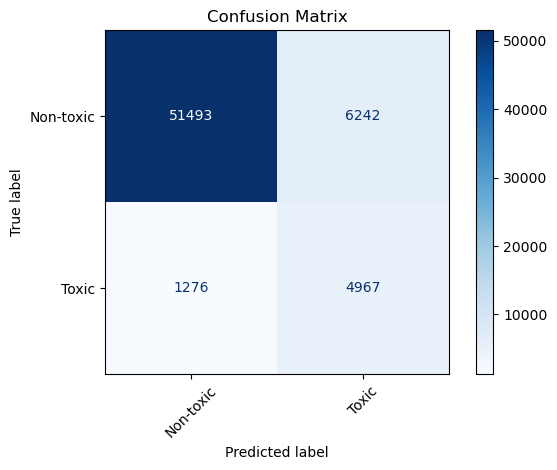

In [143]:
# Assuming best_test_df['review_comment'] and best_test_df['pred'] are your true and predicted labels
cm = confusion_matrix(best_test_df['review_comment'], best_test_df['pred'])

# Save the confusion matrix as a variable
cm_matrix = cm

# Plot confusion matrix with adjusted parameters
plt.figure(figsize=(8, 6))  # Adjust figure size as needed

disp = ConfusionMatrixDisplay(confusion_matrix=cm_matrix, display_labels=['Non-toxic', 'Toxic'])

# Plot with blue color scheme
disp.plot(cmap=plt.cm.Blues)

plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

plt.show()

<Figure size 800x600 with 0 Axes>

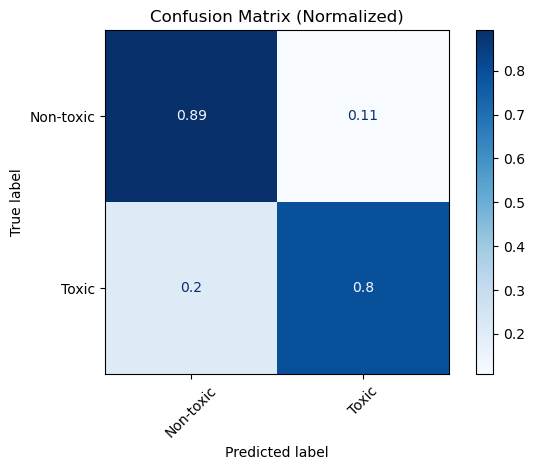

In [144]:
# Assuming best_test_df['review_comment'] and best_test_df['pred'] are your true and predicted labels
cm = confusion_matrix(best_test_df['review_comment'], best_test_df['pred'])

# Normalize confusion matrix row-wise
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix with adjusted parameters
plt.figure(figsize=(8, 6))  # Adjust figure size as needed

disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=['Non-toxic', 'Toxic'])

# Plot with adjusted color intensity in Blues colormap
disp.plot(cmap=plt.cm.Blues)

plt.title('Confusion Matrix (Normalized)')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

plt.show()

## 6.0 Toxic comment classifier function

In [146]:
# Just for the sake of demonstration we will be adding our self deprication/ joking negator
negation_words_1 = ["not", "no", "nor", "aren't", "i", "i'm", "myself", "we", "we're"]
negation_words_2 = ["not a", "nt a", "not an", "nor a", "nor an", "aren't a", "aren't an", "i am", "i'm a", "i'm an", "myself am", "we are", "we also", "am a"]
negation_words_3 = ["i am a", "i am an", "we are a"]

def preprocess_text(text):
    # Convert the input text to lowercase
    text = text.lower()

    # Process phrases with spaces (negation_words_3)
    for phrase in negation_words_3:
        pattern = re.compile(re.escape(phrase) + r'\s+(\S)')
        text = pattern.sub(lambda match: phrase.replace(' ', '') + match.group(1), text)

    # Process phrases with spaces
    for phrase in negation_words_2:
        pattern = re.compile(re.escape(phrase) + r'\s+(\S)')
        text = pattern.sub(lambda match: phrase.replace(' ', '') + match.group(1), text)
    
    # Process single-word phrases
    for phrase in negation_words:
        pattern = re.compile(re.escape(phrase) + r'\s+(\S)')
        text = pattern.sub(lambda match: phrase.replace(' ', '') + match.group(1), text)
        
    return text

In [147]:
def text_classifier(input_text):
    
    # Correct Typos
    corrected_text = correct_sentence(input_text)
    
    # Create a DataFrame with a single row containing the input text
    df = pd.DataFrame({'comment_text': [corrected_text]}, dtype=str)
    
    # Apply the preprocess_text function to the 'text_column' and replace it with the processed text
    df['comment_text'] = df['comment_text'].apply(lambda x: preprocess_text(x))
    
    
    # Clean th comments and make a new column
    clean_comments(df)
    
    # Add score column
    df['negative_score'] = df['cleaned'].apply(new_score_review)
    
    # Create a column with our predictions
    df['pred'] = df['negative_score'].apply(make_pred)
    
    # Drop column 'comment_text'
    df.drop(columns=['comment_text'], inplace=True)
    
    df['prediction'] = df['pred'].apply(lambda x: 'toxic' if x == 1 else 'non-toxic')
    
    return df

In [148]:
text_classifier("Enter Text")

,cleaned,negative_score,pred,prediction
0,enter text,0.0,0,non-toxic


## 7.0 Conclusions and Limitations

### 7.1 Conclusions on models

**Comparing all models**

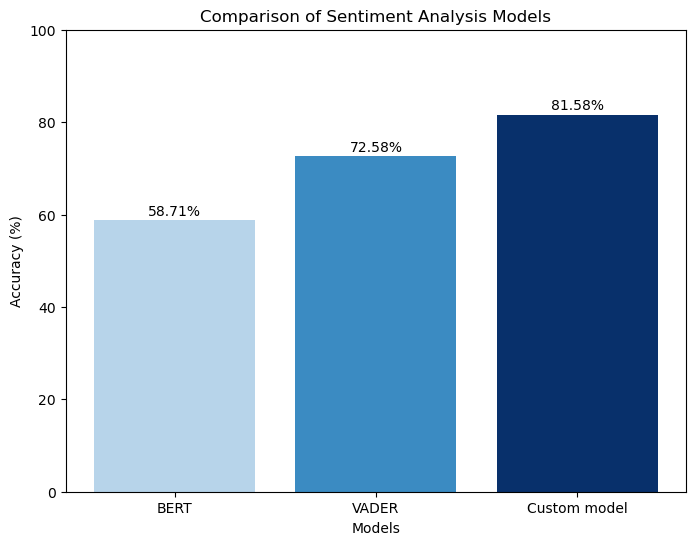

In [152]:
# Data
models = ['BERT', 'VADER', 'Custom model']
percentages = [58.71, 72.58, 81.58]

# Define colors using a colormap
colors = plt.cm.Blues(np.linspace(0.3, 1.0, len(models)))  # Adjust the range (0.3, 1.0) as needed

# Create a bar graph
plt.figure(figsize=(8, 6))
bars = plt.bar(models, percentages, color=colors)

# Adding titles and labels
plt.title('Comparison of Sentiment Analysis Models')
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')

# Display the percentages on top of the bars
for bar, percentage in zip(bars, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f'{percentage}%', ha='center', va='bottom')

# Display the plot
plt.ylim(0, 100)  # S Setting y-axis limit from 0 to 100
plt.show()

On testing, the custom model performed the best with an accuracy of 81.58%, which is 9% higher than the next best-performing VADER model.

**Custom model performance on test**

<Figure size 800x600 with 0 Axes>

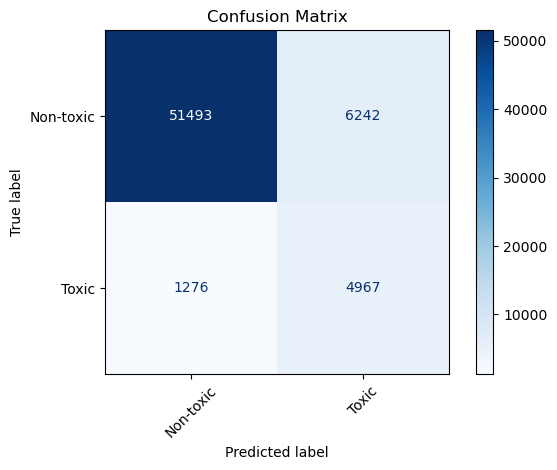

In [155]:
# Confusion matrix for custom model
cm_matrix
plt.figure(figsize=(8, 6))  # Adjust figure size as needed

disp = ConfusionMatrixDisplay(confusion_matrix=cm_matrix, display_labels=['Non-toxic', 'Toxic'])

# Plot with blue color scheme
disp.plot(cmap=plt.cm.Blues)

plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

plt.show()

The custom model demonstrated even higher accuracy on the test set, achieving 87.85%. Besides accuracy, the next best performing metric was recall at 79.1%. This is crucial and something we want to maximise as it minimises false negatives, ensuring that toxic behavior is not overlooked. False positives (FP), on the other hand, are less concerning since reported comments undergo human review to confirm toxicity and apply appropriate actions.

The difference in scores for accuracy and recall may be due to the fact that the model is better at estimating true negatives. One potential approach to address this is adjusting the threshold, although this might lead to a trade-off where increasing recall could potentially lead to a decrease in accuracy.

### 7.2 Limitations

- Unable to complete BERT fine-tuning (Long runtime).
- The 79% recall could be improved, especially considering the model's 88% accuracy. This suggests the model could better classify toxic comments as toxic.
- The model appears to be better at predicting false results versus true.
- The dataset was pulled from Wikipedia's talk page edits. Ideally, data from various social media platforms (e.g., Instagram, X, Facebook, Reddit, etc.) should be used to create a more representative and applicable model for these platforms.